### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

# Optim
from chestxray.optimizers import RAdam

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


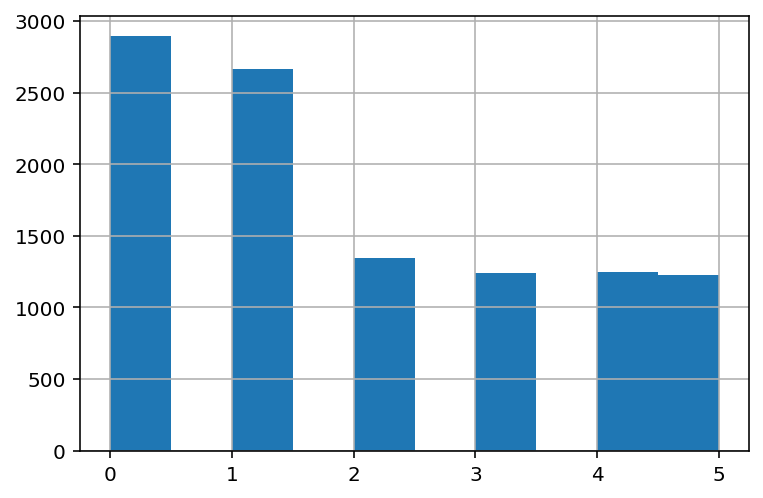

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

04-06-2020-08-31


In [10]:
# runs version 1
writer = SummaryWriter(f'runs_v1/{EXP_NAME}')

In [11]:
# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(f'runs/{EXP_NAME}')

In [9]:
# # if resume should define from what to start
PREV_NAME = "03-06-2020-07-43"
writer = SummaryWriter(f"runs_v1/{PREV_NAME}_b")

In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type),
    "none": (None, None)
}

### Train Eval Loop

In [13]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, scheduler, sch_is_epoch_type, accum_step=CFG.accum_step, checkpoint=False,
                    num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
    
    def text_preds_to_tb(outputs, labels, step):
        preds_text = text_classes_preds(outputs.to("cpu"), labels.to("cpu"))
        writer.add_text(f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds, normalize=True),
                          global_step=step)
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint['best_qwk']
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]
    
    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        
        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            # we accumulate gradients and make optimization step once per # of accum_step
            if (i+1)% accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if scheduler and not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(tag=f"lr Interim {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
            writer.add_scalar(tag=f"lr Classifier {tb_tag}:", scalar_value=optimizer.param_groups[1]["lr"], global_step=train_global_step)
            
        else:
            writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [14]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [15]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [19]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [20]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 256 img_width: 256 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 32 tile_sz: 256 batch_size: 2 accum_step: 2 dataset: patch aug_type: heavy arch: bitM finetune: False model_cls: one_layer loss: ls_soft_ce optim: radam lr: 5e-05 schedule_type: none cawr_T: 1 cawr_Tmult: 2 rlopp: 1 epoch: 30 n_fold: 4 use_amp: True


In [21]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    if schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    if schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

In [23]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patches500.h5"])
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    val_ds = train_ds
else:
    print(f"No such dataset {CFG.dataset}")

# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=1, pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=1, pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)

model_ft = PatchModel(arch=CFG.arch)
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, num_epochs=2)

KeyboardInterrupt: 

### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


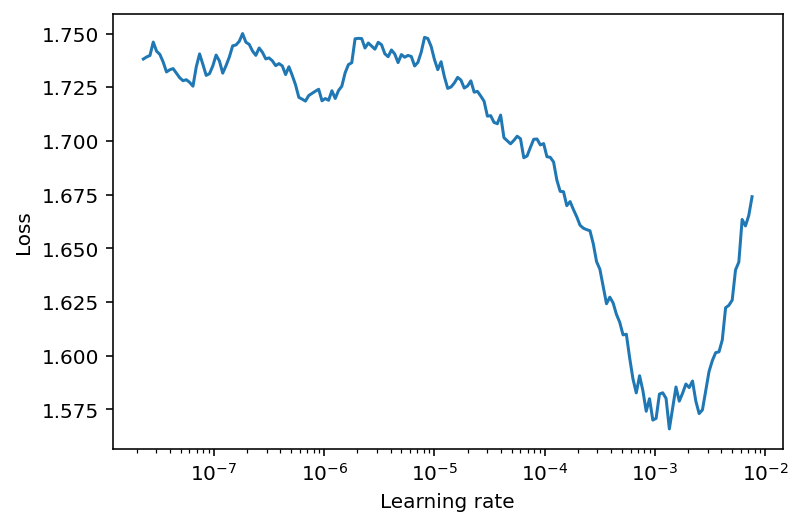

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [17]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 256
 img_width: 256
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 32
 tile_sz: 256
 batch_size: 2
 accum_step: 2
 dataset: patch
 aug_type: heavy
 arch: bitM
 finetune: False
 model_cls: one_layer
 loss: ls_soft_ce
 optim: radam
 lr: 5e-05
 schedule_type: none
 cawr_T: 1
 cawr_Tmult: 2
 rlopp: 1
 epoch: 30
 n_fold: 4
 use_amp: True



In [18]:
writer.add_text("Experiment Description:", "BitM, 256x32 heavy aug")

In [19]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

In [21]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)

model_ft = PatchModel(arch=CFG.arch)
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

In [ ]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME)

# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 0/29


  0%|          | 2/3981 [00:01<53:47,  1.23it/s]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 4/3981 [00:01<36:57,  1.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


  0%|          | 6/3981 [00:02<28:38,  2.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


  0%|          | 8/3981 [00:03<24:56,  2.66it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0


  0%|          | 10/3981 [00:03<22:43,  2.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0


  0%|          | 12/3981 [00:04<21:40,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0


  0%|          | 14/3981 [00:05<21:13,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.0


  0%|          | 16/3981 [00:05<21:20,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


  0%|          | 17/3981 [00:06<21:16,  3.11it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/3981 [00:07<21:40,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.5


  1%|          | 22/3981 [00:07<21:35,  3.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.25


  1%|          | 28/3981 [00:09<21:46,  3.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.125


 54%|█████▍    | 2142/3981 [11:34<09:53,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.125


100%|██████████| 1327/1327 [04:07<00:00,  5.37it/s]


Training Loss: 19.1603	Validation Loss: 7.1565
Counter train preds: Counter({0: 2117, 1: 1941, 2: 1052, 4: 1016, 3: 924, 5: 912})	Counter val preds: Counter({1: 1380, 2: 1170, 4: 88, 3: 16})
Epoch train QWK: 0.189	val QWK: 0.201
  Epoch 0 - Save Best Loss: 7.1565 Model
Normalized confusion matrix
[[0.         0.70401107 0.27524205 0.00829876 0.01244813 0.        ]
 [0.         0.6021021  0.38888889 0.0015015  0.00750751 0.        ]
 [0.         0.4238806  0.5641791  0.00597015 0.00597015 0.        ]
 [0.         0.32475884 0.62700965 0.00643087 0.04180064 0.        ]
 [0.         0.43769968 0.47284345 0.00638978 0.08306709 0.        ]
 [0.         0.29411765 0.58823529 0.00980392 0.10784314 0.        ]]
  Epoch 0 - Save Best QWK: 0.2008 Model
Normalized confusion matrix
[[0.         0.70401107 0.27524205 0.00829876 0.01244813 0.        ]
 [0.         0.6021021  0.38888889 0.0015015  0.00750751 0.        ]
 [0.         0.4238806  0.5641791  0.00597015 0.00597015 0.        ]
 [0.        

 32%|███▏      | 1282/3981 [06:55<14:10,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.125


100%|██████████| 1327/1327 [04:16<00:00,  5.18it/s]


Training Loss: 4.5010	Validation Loss: 5.2417
Counter train preds: Counter({0: 2169, 1: 1980, 2: 1080, 5: 926, 4: 910, 3: 897})	Counter val preds: Counter({0: 2631, 5: 21, 2: 2})
Epoch train QWK: 0.298	val QWK: 0.029
  Epoch 1 - Save Best Loss: 5.2417 Model
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.97427653 0.         0.00321543 0.         0.         0.02250804]
 [0.99041534 0.         0.00319489 0.         0.         0.00638978]
 [0.96078431 0.         0.         0.         0.         0.03921569]]
Epoch 2/29


 34%|███▍      | 1360/3981 [07:21<13:45,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.25


 85%|████████▍ | 3372/3981 [18:15<03:14,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.25


100%|██████████| 1327/1327 [04:07<00:00,  5.37it/s]


Training Loss: 2.8300	Validation Loss: 2.3861
Counter train preds: Counter({0: 2281, 1: 2006, 2: 1111, 5: 878, 4: 846, 3: 840})	Counter val preds: Counter({0: 2286, 3: 310, 5: 54, 2: 4})
Epoch train QWK: 0.397	val QWK: 0.277
  Epoch 2 - Save Best Loss: 2.3861 Model
Normalized confusion matrix
[[0.99861687 0.         0.         0.00138313 0.         0.        ]
 [0.97597598 0.         0.003003   0.02102102 0.         0.        ]
 [0.87462687 0.         0.00597015 0.11940299 0.         0.        ]
 [0.72025723 0.         0.         0.26045016 0.         0.0192926 ]
 [0.74121406 0.         0.         0.22044728 0.         0.03833866]
 [0.53921569 0.         0.         0.34313725 0.         0.11764706]]
  Epoch 2 - Save Best QWK: 0.2770 Model
Normalized confusion matrix
[[0.99861687 0.         0.         0.00138313 0.         0.        ]
 [0.97597598 0.         0.003003   0.02102102 0.         0.        ]
 [0.87462687 0.         0.00597015 0.11940299 0.         0.        ]
 [0.72025723 0. 

100%|██████████| 1327/1327 [04:11<00:00,  5.27it/s]


Training Loss: 2.2191	Validation Loss: 1.7778
Counter train preds: Counter({0: 2327, 1: 2049, 2: 1043, 5: 893, 3: 832, 4: 818})	Counter val preds: Counter({1: 1224, 3: 980, 0: 369, 5: 79, 2: 2})
Epoch train QWK: 0.507	val QWK: 0.621
  Epoch 3 - Save Best Loss: 1.7778 Model
Normalized confusion matrix
[[0.43706777 0.48409405 0.         0.07745505 0.         0.00138313]
 [0.04504505 0.78228228 0.         0.17267267 0.         0.        ]
 [0.01492537 0.52537313 0.00298507 0.45373134 0.         0.00298507]
 [0.02250804 0.23151125 0.         0.7266881  0.         0.0192926 ]
 [0.00958466 0.2428115  0.00319489 0.68690096 0.         0.05750799]
 [0.02614379 0.09477124 0.         0.70588235 0.         0.17320261]]
  Epoch 3 - Save Best QWK: 0.6207 Model
Normalized confusion matrix
[[0.43706777 0.48409405 0.         0.07745505 0.         0.00138313]
 [0.04504505 0.78228228 0.         0.17267267 0.         0.        ]
 [0.01492537 0.52537313 0.00298507 0.45373134 0.         0.00298507]
 [0.0225

 39%|███▊      | 1538/3981 [08:14<12:57,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:14<00:00,  5.22it/s]

Training Loss: 1.8518	Validation Loss: 1.8433
Counter train preds: Counter({0: 2368, 1: 2052, 2: 1015, 5: 887, 4: 839, 3: 801})	Counter val preds: Counter({1: 2047, 4: 603, 5: 2, 2: 1, 3: 1})
Epoch train QWK: 0.580	val QWK: 0.587
Epoch 5/29



 18%|█▊        | 718/3981 [03:50<17:17,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


 84%|████████▍ | 3340/3981 [17:53<03:21,  3.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:08<00:00,  5.33it/s]


Training Loss: 1.5739	Validation Loss: 1.2972
Counter train preds: Counter({0: 2479, 1: 2085, 2: 933, 5: 910, 4: 823, 3: 732})	Counter val preds: Counter({1: 1085, 0: 529, 2: 457, 4: 387, 5: 196})
Epoch train QWK: 0.627	val QWK: 0.722
  Epoch 5 - Save Best Loss: 1.2972 Model
Normalized confusion matrix
[[0.60027663 0.38589212 0.00138313 0.         0.01106501 0.00138313]
 [0.04804805 0.77327327 0.16966967 0.         0.00900901 0.        ]
 [0.02686567 0.38507463 0.54328358 0.         0.04179104 0.00298507]
 [0.05466238 0.22508039 0.29903537 0.         0.31832797 0.10289389]
 [0.0543131  0.20766773 0.12779553 0.         0.50798722 0.10223642]
 [0.06535948 0.08823529 0.09150327 0.         0.33006536 0.4248366 ]]
  Epoch 5 - Save Best QWK: 0.7224 Model
Normalized confusion matrix
[[0.60027663 0.38589212 0.00138313 0.         0.01106501 0.00138313]
 [0.04804805 0.77327327 0.16966967 0.         0.00900901 0.        ]
 [0.02686567 0.38507463 0.54328358 0.         0.04179104 0.00298507]
 [0.05

 57%|█████▋    | 2256/3981 [12:15<09:06,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:12<00:00,  5.26it/s]

Training Loss: 1.4397	Validation Loss: 1.3500
Counter train preds: Counter({0: 2519, 1: 2075, 2: 947, 5: 869, 4: 816, 3: 736})	Counter val preds: Counter({0: 1109, 2: 941, 4: 315, 5: 178, 1: 107, 3: 4})
Epoch train QWK: 0.670	val QWK: 0.675
Epoch 7/29



 14%|█▍        | 548/3981 [02:58<18:14,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:07<00:00,  5.36it/s]


Training Loss: 1.3493	Validation Loss: 1.2922
Counter train preds: Counter({0: 2503, 1: 2176, 5: 874, 2: 869, 3: 771, 4: 769})	Counter val preds: Counter({1: 990, 5: 824, 0: 777, 4: 45, 2: 18})
Epoch train QWK: 0.689	val QWK: 0.731
  Epoch 7 - Save Best Loss: 1.2922 Model
Normalized confusion matrix
[[0.85892116 0.1175657  0.         0.         0.00138313 0.02213001]
 [0.09159159 0.87087087 0.0045045  0.         0.0015015  0.03153153]
 [0.03283582 0.63880597 0.03283582 0.         0.02686567 0.26865672]
 [0.08360129 0.19614148 0.0096463  0.         0.04180064 0.66881029]
 [0.09904153 0.13099042 0.         0.         0.05750799 0.71246006]
 [0.08823529 0.02941176 0.00326797 0.         0.00980392 0.86928105]]
  Epoch 7 - Save Best QWK: 0.7313 Model
Normalized confusion matrix
[[0.85892116 0.1175657  0.         0.         0.00138313 0.02213001]
 [0.09159159 0.87087087 0.0045045  0.         0.0015015  0.03153153]
 [0.03283582 0.63880597 0.03283582 0.         0.02686567 0.26865672]
 [0.08360

  4%|▍         | 156/3981 [00:50<20:06,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:09<00:00,  5.31it/s]

Training Loss: 1.2837	Validation Loss: 1.3481
Counter train preds: Counter({0: 2570, 1: 2151, 5: 906, 2: 845, 4: 778, 3: 712})	Counter val preds: Counter({1: 1513, 3: 365, 0: 362, 4: 293, 2: 87, 5: 34})
Epoch train QWK: 0.714	val QWK: 0.680
Epoch 9/29



  8%|▊         | 306/3981 [01:38<19:37,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


 54%|█████▎    | 2134/3981 [11:32<10:09,  3.03it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:13<00:00,  5.23it/s]

Training Loss: 1.2326	Validation Loss: 1.3232
Counter train preds: Counter({0: 2541, 1: 2245, 5: 892, 2: 820, 4: 751, 3: 713})	Counter val preds: Counter({0: 962, 1: 810, 3: 471, 2: 233, 5: 178})
Epoch train QWK: 0.736	val QWK: 0.672
Epoch 10/29



 54%|█████▍    | 2160/3981 [11:40<09:33,  3.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


100%|██████████| 1327/1327 [04:14<00:00,  5.21it/s]


Training Loss: 1.2019	Validation Loss: 1.2750
Counter train preds: Counter({0: 2557, 1: 2232, 5: 903, 2: 795, 4: 767, 3: 708})	Counter val preds: Counter({2: 886, 0: 753, 1: 670, 4: 208, 5: 137})
Epoch train QWK: 0.741	val QWK: 0.698
  Epoch 10 - Save Best Loss: 1.2750 Model
Normalized confusion matrix
[[0.86860304 0.08713693 0.03319502 0.         0.00829876 0.00276625]
 [0.07807808 0.70720721 0.21021021 0.         0.0045045  0.        ]
 [0.02686567 0.28656716 0.68656716 0.         0.         0.        ]
 [0.06752412 0.06430868 0.74919614 0.         0.08360129 0.03536977]
 [0.06709265 0.04792332 0.45047923 0.         0.36741214 0.06709265]
 [0.07189542 0.01633987 0.38562092 0.         0.18954248 0.33660131]]
Epoch 11/29


 15%|█▍        | 586/3981 [03:08<18:04,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


 49%|████▉     | 1964/3981 [10:33<10:41,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:18<00:00,  5.13it/s]


Training Loss: 1.1942	Validation Loss: 1.1692
Counter train preds: Counter({0: 2558, 1: 2249, 5: 900, 2: 792, 4: 764, 3: 699})	Counter val preds: Counter({0: 904, 1: 730, 5: 417, 3: 399, 2: 201, 4: 3})
Epoch train QWK: 0.740	val QWK: 0.766
  Epoch 11 - Save Best Loss: 1.1692 Model
Normalized confusion matrix
[[0.92807746 0.05809129 0.00276625 0.00138313 0.         0.00968188]
 [0.14714715 0.74474474 0.08258258 0.02252252 0.         0.003003  ]
 [0.07761194 0.40597015 0.28656716 0.20597015 0.         0.0238806 ]
 [0.11254019 0.11254019 0.08038585 0.49517685 0.         0.19935691]
 [0.14057508 0.0543131  0.0543131  0.36421725 0.00638978 0.38019169]
 [0.09803922 0.0130719  0.01960784 0.1503268  0.00326797 0.71568627]]
  Epoch 11 - Save Best QWK: 0.7657 Model
Normalized confusion matrix
[[0.92807746 0.05809129 0.00276625 0.00138313 0.         0.00968188]
 [0.14714715 0.74474474 0.08258258 0.02252252 0.         0.003003  ]
 [0.07761194 0.40597015 0.28656716 0.20597015 0.         0.0238806 ]

 13%|█▎        | 512/3981 [02:45<18:27,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


 24%|██▍       | 948/3981 [05:05<16:23,  3.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.5


100%|██████████| 1327/1327 [04:15<00:00,  5.20it/s]


Training Loss: 1.1954	Validation Loss: 1.1722
Counter train preds: Counter({0: 2554, 1: 2235, 5: 886, 4: 794, 2: 775, 3: 718})	Counter val preds: Counter({1: 1001, 0: 611, 3: 359, 5: 336, 4: 179, 2: 168})
Epoch train QWK: 0.749	val QWK: 0.769
  Epoch 12 - Save Best QWK: 0.7694 Model
Normalized confusion matrix
[[0.73582296 0.20055325 0.00138313 0.02489627 0.02351314 0.01383126]
 [0.04504505 0.88138138 0.02102102 0.04654655 0.00600601 0.        ]
 [0.01791045 0.54626866 0.21492537 0.18208955 0.0119403  0.02686567]
 [0.06109325 0.15755627 0.13504823 0.39549839 0.08038585 0.17041801]
 [0.02875399 0.09584665 0.08626198 0.26517572 0.28753994 0.23642173]
 [0.04901961 0.02287582 0.03921569 0.14052288 0.12745098 0.62091503]]
Epoch 13/29


 87%|████████▋ | 3464/3981 [18:42<02:43,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


100%|██████████| 1327/1327 [04:14<00:00,  5.21it/s]

Training Loss: 1.1819	Validation Loss: 1.2266
Counter train preds: Counter({0: 2564, 1: 2311, 5: 872, 2: 749, 4: 742, 3: 724})	Counter val preds: Counter({1: 822, 0: 781, 2: 568, 4: 270, 3: 156, 5: 57})
Epoch train QWK: 0.742	val QWK: 0.705
Epoch 14/29



 52%|█████▏    | 2072/3981 [11:11<10:05,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


 52%|█████▏    | 2088/3981 [11:16<10:02,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:05<00:00,  5.42it/s]

Training Loss: 1.1747	Validation Loss: 1.1845
Counter train preds: Counter({0: 2554, 1: 2227, 5: 931, 2: 797, 4: 761, 3: 692})	Counter val preds: Counter({1: 983, 0: 729, 5: 414, 2: 382, 4: 75, 3: 71})
Epoch train QWK: 0.753	val QWK: 0.746
Epoch 15/29



 40%|███▉      | 1586/3981 [08:34<12:37,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:00<00:00,  5.51it/s]

Training Loss: 1.1715	Validation Loss: 1.1738
Counter train preds: Counter({0: 2569, 1: 2255, 5: 921, 4: 748, 2: 741, 3: 728})	Counter val preds: Counter({1: 896, 0: 778, 2: 409, 4: 244, 3: 167, 5: 160})
Epoch train QWK: 0.753	val QWK: 0.720
Epoch 16/29



 41%|████▏     | 1646/3981 [08:55<12:17,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


 78%|███████▊  | 3110/3981 [16:53<04:35,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:16<00:00,  5.18it/s]

Training Loss: 1.1713	Validation Loss: 1.3259
Counter train preds: Counter({0: 2532, 1: 2309, 5: 872, 4: 793, 3: 739, 2: 717})	Counter val preds: Counter({0: 1155, 5: 745, 2: 432, 1: 244, 4: 43, 3: 35})
Epoch train QWK: 0.745	val QWK: 0.733
Epoch 17/29



 92%|█████████▏| 3678/3981 [20:02<01:35,  3.16it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0


100%|█████████▉| 3968/3981 [21:37<00:04,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


100%|██████████| 1327/1327 [04:14<00:00,  5.21it/s]

Training Loss: 1.1735	Validation Loss: 1.3451
Counter train preds: Counter({0: 2558, 1: 2256, 5: 924, 3: 747, 4: 742, 2: 735})	Counter val preds: Counter({5: 848, 0: 785, 1: 584, 4: 253, 2: 184})
Epoch train QWK: 0.745	val QWK: 0.717
Epoch 18/29



 67%|██████▋   | 2674/3981 [14:20<06:50,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0


 84%|████████▍ | 3348/3981 [17:57<03:18,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.5


 84%|████████▍ | 3354/3981 [17:59<03:17,  3.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.25


100%|██████████| 1327/1327 [04:10<00:00,  5.30it/s]

Training Loss: 1.1787	Validation Loss: 1.2389
Counter train preds: Counter({0: 2541, 1: 2271, 5: 917, 4: 793, 2: 749, 3: 691})	Counter val preds: Counter({1: 1210, 0: 467, 4: 412, 3: 314, 5: 156, 2: 95})
Epoch train QWK: 0.744	val QWK: 0.731
Epoch 19/29



100%|██████████| 1327/1327 [04:09<00:00,  5.33it/s]

Training Loss: 1.1880	Validation Loss: 1.2366
Counter train preds: Counter({0: 2530, 1: 2253, 5: 901, 4: 806, 2: 756, 3: 716})	Counter val preds: Counter({1: 1158, 0: 756, 5: 347, 2: 287, 3: 54, 4: 52})
Epoch train QWK: 0.747	val QWK: 0.714
Epoch 20/29



 14%|█▍        | 560/3981 [03:03<18:12,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.5


 71%|███████   | 2812/3981 [15:13<06:05,  3.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.5


 80%|███████▉  | 3166/3981 [17:08<04:19,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.25


 80%|███████▉  | 3174/3981 [17:10<04:14,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 0.125


100%|██████████| 1327/1327 [04:11<00:00,  5.29it/s]

Training Loss: 1.2031	Validation Loss: 1.4486
Counter train preds: Counter({0: 2572, 1: 2256, 5: 920, 2: 770, 4: 757, 3: 687})	Counter val preds: Counter({1: 1220, 2: 558, 0: 462, 4: 339, 3: 64, 5: 11})
Epoch train QWK: 0.741	val QWK: 0.675
Epoch 21/29



 25%|██▌       | 1002/3981 [05:59<16:59,  2.92it/s]

#### Resume Training

In [19]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)


checkpoint = torch.load(f'{MODEL_PATH}/{PREV_NAME}_loss.pth')

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint['model_state_dict'])
model_ft.to(device)
criterion = LOSSES[CFG.loss]

if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ])
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# set smaller lr here
for param_group in optimizer.param_groups:
    param_group['lr'] /= 2

scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=True)

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, checkpoint=checkpoint, model_name=PREV_NAME)

# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
